## Imports

In [1]:
import tensorflow as tf
import os # accessing file systems
import matplotlib.pyplot as plt

In [2]:
import cv2
import numpy as np
import pandas as pd

In [3]:
class_list = os.listdir("data")
print(class_list)

['bengal_cat', 'bombay_cat', 'himalayan_cat', 'persian_cat']


In [4]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
gpus

[]

## Modifying data names for easy labeling

In [8]:
# os.listdir(os.path.join("data", class_list[0]))

In [ ]:
# breed_path = "data\breed" = os.path.join("data", breed)
# list = os.listdir(breed_path) # lists name of all images
# print(list)
image_exts = ['.jpeg','.jpg', '.bmp', '.png']
for breed in class_list:
    for cnt, filename in enumerate(os.listdir(os.path.join("data", breed))):
        img_path = os.path.join(os.path.join("data", breed), filename) # path of current image
        # print(img_path)
        img_path_ext = os.path.splitext(img_path)[1] # we get the extension of image at the path
        # print(img_path_ext)
        if(img_path_ext in image_exts):
            dst = f"{breed}{str(cnt)}{img_path_ext}"
            src = f"{os.path.join('data', breed)}/{filename}"  # foldername/filename, if .py file is outside folder
            dst = f"{os.path.join('data', breed)}/{dst}"
            os.rename(src, dst)


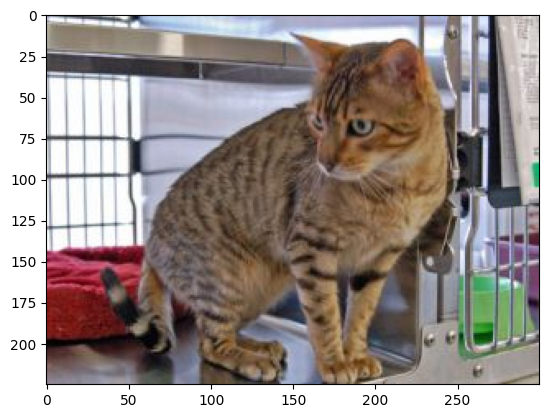

In [6]:
sample_img = cv2.imread(os.path.join("data", "bengal_cat", "bengal_cat1.jpg"))
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)) # openCV reads as BGR and not RGB

## Loading the dataset

In [24]:
# tf.keras.utils.image_dataset_from_directory??

In [7]:
data = tf.keras.utils.image_dataset_from_directory("data",
                                                   image_size=(256, 256),
                                                   class_names=class_list
                                                   )
# builds the dataset by labeling the images, resizing the images and even batching the images

Found 6905 files belonging to 4 classes.


In [8]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print(batch[0].shape, batch[1].shape)

(32, 256, 256, 3) (32,)


In [9]:
batch[1]
# 0 - bengal
# 1 - bombay
# 2 - himalayan
# 3 - persian

array([0, 2, 2, 3, 1, 2, 1, 2, 0, 0, 0, 1, 1, 1, 0, 1, 3, 3, 3, 3, 0, 3,
       2, 2, 1, 1, 2, 1, 1, 2, 0, 3])

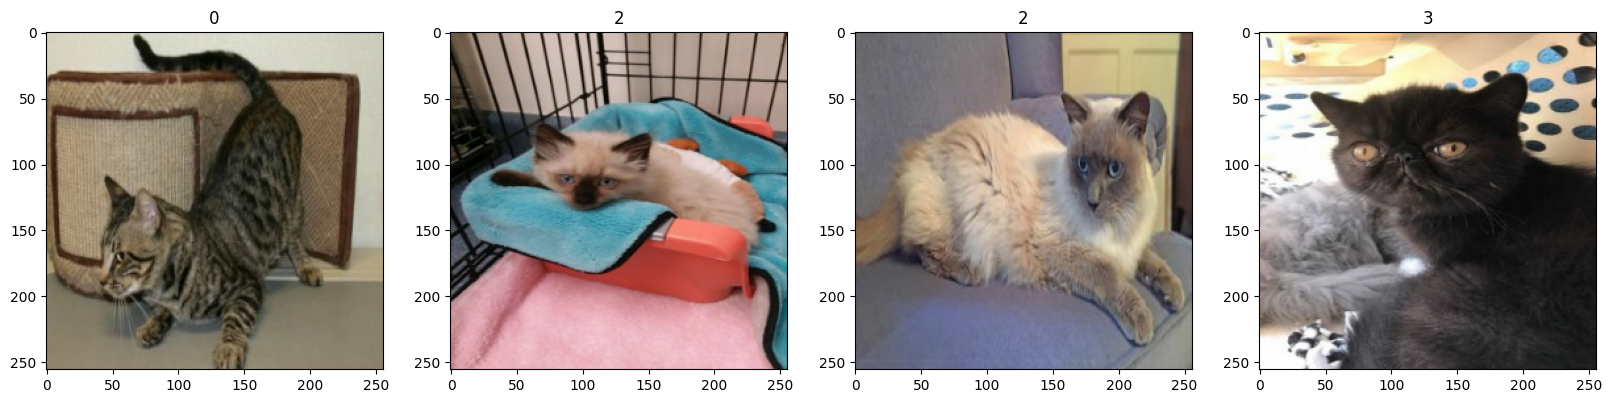

In [10]:
# let's figure the current batch out 😁
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]): # 1st 4 images of current batch
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocess the data

In [11]:
# scale the data
data = data.map(lambda x, y: (x/255.0, y)) # x=pixel values and y=label

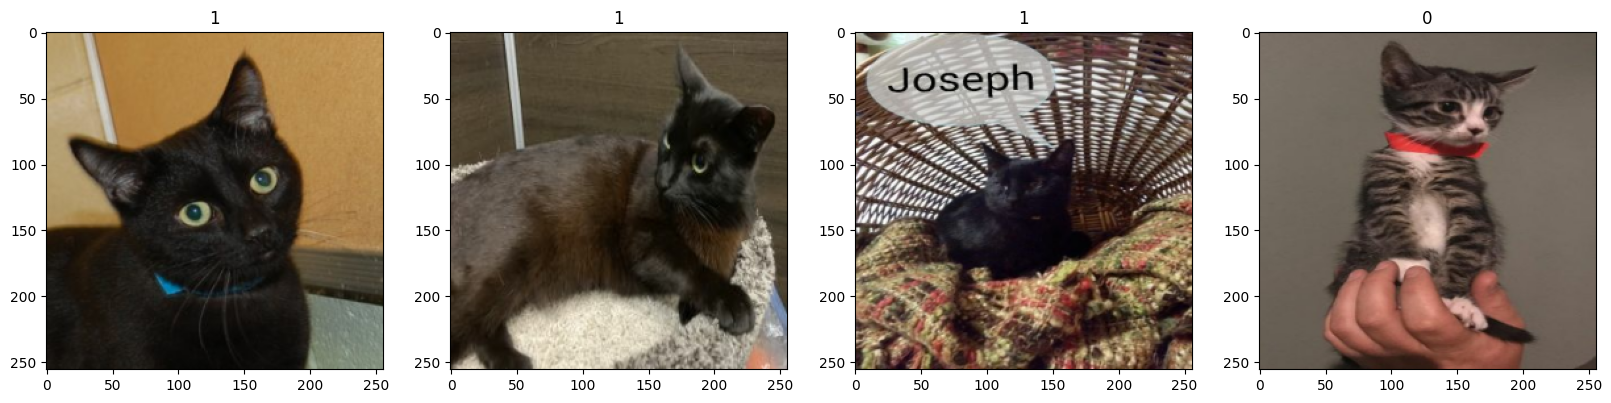

In [12]:
new_batch = data.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(new_batch[0][:4]): # 1st 4 images of current batch
    ax[idx].imshow(img)
    ax[idx].title.set_text(new_batch[1][idx])

plt.show()

# note that the pixel values values are now between 0. and 1.

## Train-Test-Validation Split

In [13]:
len(data) # number of batches

216

In [36]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)
print(train_size+val_size+test_size) # = 216 is a must

215


In [37]:
# split the data
train = data.take(train_size) # tf method to take amount of data
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [38]:
len(train), len(val), len(test) # number of batches

(151, 43, 21)

## Training the CNN model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [18]:
model = Sequential()

In [20]:
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# model.add(Conv2D(64, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Conv2D(16, (3,3), 1, activation='relu'))
# model.add(MaxPooling2D())

model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(4))

In [21]:
model.compile(optimizer="adam",
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"]
              )

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [23]:
logdir = "logs"
# directory where all the model training stages (checkpoints) will be added

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
hist = model.fit(train, epochs=2, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/2
151/151 [==============================] - 478s 3s/step - loss: 1.1026 - accuracy: 0.4998 - val_loss: 0.9666 - val_accuracy: 0.5836
Epoch 2/2
151/151 [==============================] - 458s 3s/step - loss: 0.8749 - accuracy: 0.6316 - val_loss: 0.8679 - val_accuracy: 0.6461


In [ ]:
# hist.history

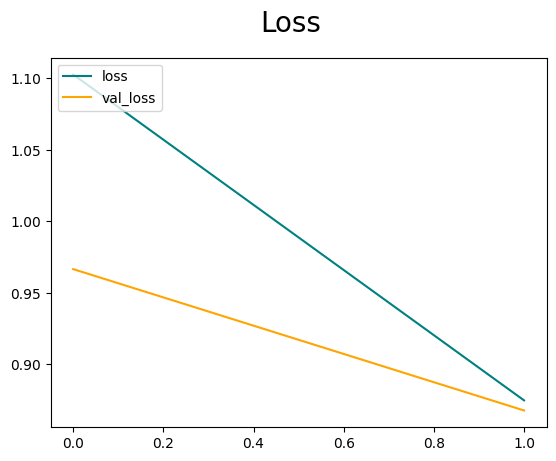

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

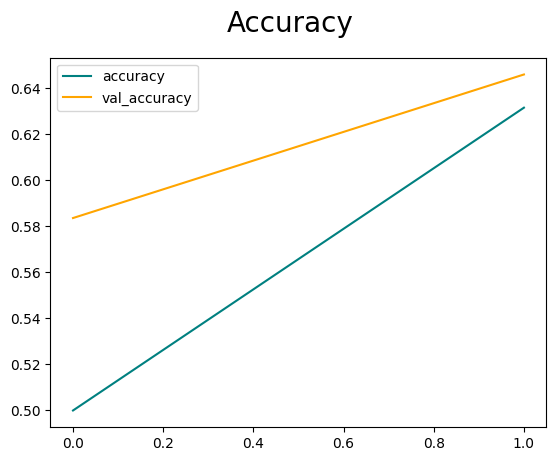

In [27]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluation of the model

In [28]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [29]:
pre = Precision()
recall = Recall()
binacc = BinaryAccuracy()

In [55]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat = tf.nn.softmax(yhat, axis=1)
    # print(yhat)
    yhat = tf.math.argmax(yhat, axis=1)
    pre.update_state(y, yhat)
    recall.update_state(y, yhat)
    binacc.update_state(y, yhat)

1/1 [==============================] - 1s 503ms/step


In [56]:
print(f"Precision is {pre.result()}, Recall is {recall.result()}, Accuracy is {binacc.result()}")

Precision is 0.8446969985961914, Recall is 0.927234947681427, Accuracy is 0.4270833432674408


## Testing on unseen data

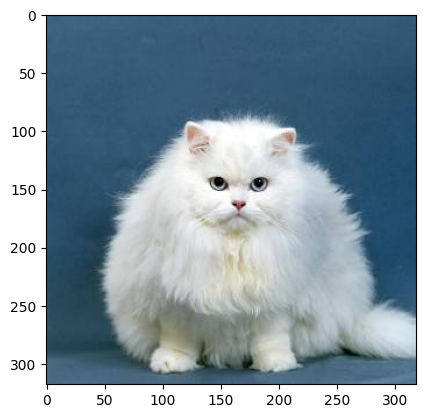

In [57]:
test_img = cv2.imread("test.jpg")
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show()

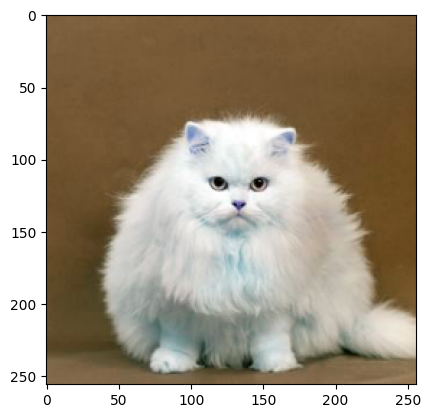

In [58]:
resize_test = tf.image.resize(test_img, (256,256))
plt.imshow(resize_test.numpy().astype(int))
plt.show()

In [59]:
resize_test.shape, np.expand_dims(resize_test/255.0, 0).shape

(TensorShape([256, 256, 3]), (1, 256, 256, 3))

In [6]:
yhat = tf.math.argmax(tf.nn.softmax(model.predict(np.expand_dims(resize_test/255.0, 0)), axis=1), axis=1) # keras expects data as batches

NameError: name 'model' is not defined

In [61]:
match(yhat):
    case 0: print("predicted breed - bengal")
    case 1: print("predicted breed - bombay")
    case 1: print("predicted breed - himalayan")
    case 1: print("predicted breed - persian")
    case _: print("none of known breeds !")

array([[-0.12723672, -4.063577  ,  1.2062575 ,  1.6400465 ]],
      dtype=float32)

In [7]:
# tf.nn.softmax(yhat, axis=1)